# PyTorch Neural Network for Plank classification (High back, Low back, Correct)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [32]:
# Load data
data = pd.read_csv('ds.csv')
data = data.dropna()

data


,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
0,C,0.241842,0.435841,-0.002772,0.999881,0.274594,0.341100,-0.188556,0.999743,0.296270,...,0.174394,0.529667,0.801527,0.555134,-0.070554,0.776038,0.794738,0.537268,0.102899,0.440595
1,C,0.237662,0.440657,-0.003768,0.999896,0.274228,0.339355,-0.189618,0.999759,0.296200,...,0.184522,0.553936,0.803268,0.557891,-0.061299,0.799590,0.795147,0.533265,0.113687,0.479885
2,C,0.237591,0.441506,-0.003623,0.999899,0.274257,0.340742,-0.190390,0.999762,0.295690,...,0.187280,0.553449,0.803358,0.558061,-0.053722,0.798296,0.797029,0.534547,0.120511,0.478705
3,C,0.238127,0.441322,-0.000322,0.999902,0.274333,0.339990,-0.190143,0.999760,0.295731,...,0.178452,0.561389,0.803932,0.554631,-0.059433,0.804831,0.799963,0.532089,0.107540,0.488323
4,C,0.238066,0.440833,0.003989,0.999907,0.274171,0.343735,-0.187406,0.999760,0.295011,...,0.172571,0.567620,0.802851,0.554338,-0.064519,0.809826,0.799751,0.530627,0.102761,0.495874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29225,H,0.686869,0.539877,0.026248,0.999214,0.686127,0.417011,0.160699,0.996643,0.712502,...,0.038186,0.964841,0.222027,0.581916,0.161242,0.449509,0.215568,0.605296,-0.018090,0.928651
29226,H,0.712149,0.544478,0.014878,0.999212,0.693965,0.417500,0.159935,0.996030,0.718311,...,0.057837,0.965207,0.225002,0.589805,0.194644,0.456460,0.215463,0.608492,-0.008770,0.931416
29227,H,0.735630,0.543294,0.007467,0.999246,0.695831,0.417349,0.155194,0.995723,0.720067,...,0.086010,0.966131,0.226601,0.598075,0.219305,0.470830,0.220079,0.614120,0.026265,0.934942
29228,H,0.775572,0.517579,0.012821,0.999378,0.704168,0.404210,0.162908,0.995909,0.730823,...,0.070911,0.967070,0.238810,0.610591,0.198591,0.496140,0.228907,0.625559,0.018591,0.938905


In [33]:
# Prepare data
y = data['label'].values

X = data.drop('label', axis=1).values

# encode labels (H, L, C) to (2, 1, 0)
y = np.where(y == 'H', 2, y)
y = np.where(y == 'L', 1, y)
y = np.where(y == 'C', 0, y)

# Convert labels to integers
y = y.astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [34]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=68, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=20)
        self.out = nn.Linear(in_features=20, out_features=3)
        self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after second layer
        x = self.out(x)
        x = F.softmax(x, dim=1)  # Apply softmax to the output layer
        return x
    

In [35]:
# Initialize model
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=68, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [36]:
# Define optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


In [37]:
# Train model
epochs = 100
losses = []

for i in range(epochs):
    y_pred = net.forward(X_train)
    loss = loss_fn(y_pred, y_train)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f'Epoch {i} loss: {loss.item()}')

Epoch 0 loss: 1.0991390943527222
Epoch 10 loss: 0.9004423022270203
Epoch 20 loss: 0.7282534241676331
Epoch 30 loss: 0.6506009101867676
Epoch 40 loss: 0.6149715781211853
Epoch 50 loss: 0.6015867590904236
Epoch 60 loss: 0.5927668213844299
Epoch 70 loss: 0.5867854356765747
Epoch 80 loss: 0.5828245878219604
Epoch 90 loss: 0.5818780064582825


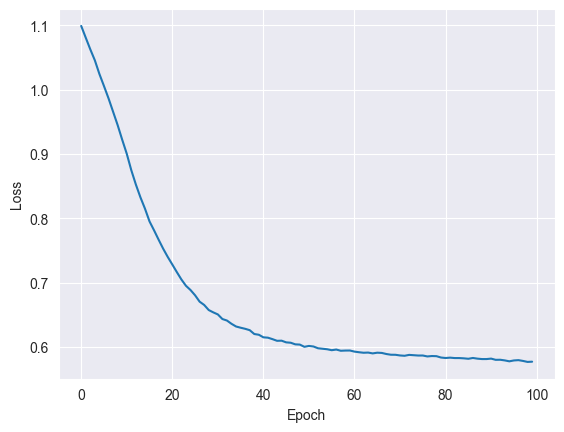

In [38]:
# Plot loss
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [39]:
# Evaluate model
y_pred = net.forward(X_test)
loss = loss_fn(y_pred, y_test)
loss

tensor(0.5787, grad_fn=<NllLossBackward0>)

In [40]:
# Convert predictions to labels
y_pred = torch.argmax(y_pred, dim=1)

In [41]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[1995   20    9]
 [  74 1883    0]
 [  35    0 1830]]


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2024
           1       0.99      0.96      0.98      1957
           2       1.00      0.98      0.99      1865

    accuracy                           0.98      5846
   macro avg       0.98      0.98      0.98      5846
weighted avg       0.98      0.98      0.98      5846



In [44]:
# Save model
torch.save(net, '/Models/Core/Plank/old/nn_model.pth')
